# CS155 Project 3: Shakespearean Sonnets

In [163]:
import random
import numpy as np
import os
import nltk
from IPython.display import HTML
from nltk.corpus import cmudict
from collections import Counter
from HMM_Project3 import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    visualize_sparsities,
    animate_emission
)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

## Preprocessing:

#### Initial Attempt:
- Process the words line by line
- Remove line containing numbering for poem (1, 2, 3, etc.)
- Change all the words to lowercase
- Uses TweetTokenizer to separate words (retains apostrophes and hyphens)
- Remove all punctualization

In [2]:
def preprocess_init(text):
    # Convert text to dataset.
    lines = text.split('\n')

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        # Separate into words using TweetTokenizer and lowercase
        sentence = tknzr.tokenize(line)
        # Skip if line is poem numbering
        if sentence != [] and not sentence[0].isnumeric():
            obs_elem = []
            punct = ".',':;!?()"; 
            
            for word in sentence:
                # Remove intermediate punctuation
                if not word in punct:
                    # Turn to lowercase
                    word = word.lower()
                    if word not in obs_map:
                        # Add unique words to the observations map.
                        obs_map[word] = obs_counter
                        obs_counter += 1

                    # Add the encoded word.
                    obs_elem.append(obs_map[word])

            # Add the encoded sequence.
            obs.append(obs_elem)

    return obs, obs_map

In [3]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
obs, obs_map = preprocess_init(text)

## Unsupervised Learning and Poetry Generation with HMMs:

If we were to do a training/testing split for using validation to determine the number of states, we wouldn't be able to guarantee that every state would end up in the training set since some words only appear once in all of the poems. So, we will instead generate some sample poems and subjectively judge the best number of states, as suggested on Piazza.

In [4]:
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

#### Initial Attempt:
- Determine number of words in each line by sampling randomly from all of the line lengths
- Dictate all of the end-line punctuation to be commas except for the final line, which ends with a period.
- Use characteristic 14-phrase structure.

In [5]:
# Generate array of all shakespeare line lengths (in terms of number of words)
line_lens = [len(i) for i in obs]

In [6]:
def generate_poem_init(hmm, obs_map, line_lens):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)
    
    poem = ""
    
    for i in range(14):
        # Get desired line length:
        n_words = random.choice(line_lens)
        emission, states = hmm.generate_emission(n_words)
        sentence = [obs_map_r[i] for i in emission]
        
        formatted = ' '.join(sentence).capitalize()
        if i < 13:
            formatted += ",\n"
        else:
            formatted += "."
        
        poem += formatted

    return poem

Generate poems for 1, 2, 4, 8, and 16 hidden states to assess coherency:

In [105]:
hmm2 = unsupervised_HMM(obs, 2, 100)
print('\nSample Poem:\n====================')
print(generate_poem_init(hmm2, obs_map, line_lens))


Sample Poem:
Of climbed so same shop and they place from,
Walls of each what my her state be,
Dear me posterity within in ) love's thy,
Poet white verse thy the gone dote my,
The me to that within heaven dispense i,
From me or it beated look papers sharpened,
Like set here's all insults adder's jacks that esteeming,
For upon the all of the to fool,
Are or course the rest swear your o makes,
That bett'ring a thee beauty me for poor,
Kind are anew tyrant worth lose ocean change should i,
You more put my as which strive,
And seeking and then and that,
Truth the watchman nor his for use they.


In [106]:
hmm4 = unsupervised_HMM(obs, 4, 100)
print('\nSample Poem:\n====================')
print(generate_poem_init(hmm4, obs_map, line_lens))


Sample Poem:
Fair hide share beauty's tongue and of will,
Both with fear are his that,
Of is were but what others hate thy lest with,
In but dear thee mistress hath,
His sweetest send thy to votary and cast,
Long give and wand'ring still whereto to eyes cherubins,
To gave methinks my argument side my is enmity,
Vexed o was on i and you to,
Thy quite eyes your to paying indeed conspire which,
Memory thou laid impute niggard my ushers happy and,
Particulars power and tell aspect flatter his full none,
Heaven the sight saucy state a pattern beauties sweet hung left,
And thee mine your buds,
No frown this my black to this tell best.


In [112]:
hmm8 = unsupervised_HMM(obs, 8, 100)
print('\nSample Poem:\n====================')
print(generate_poem_init(hmm8, obs_map, line_lens))


Sample Poem:
Like found in importune the with this waste,
Title a as a interest beauty's sickness pent thee,
Made by in up in my pierced in strong,
Better burthen leaves with clouds so excellent,
Be gainst at much so perish who of,
See that nymphs let unfair of,
All jacks those grief's moment yours touches work,
Nor it think if thee for,
That or we have thy straight is thy,
Or and but boast my slave or,
Bars breast both sun dead thy in fears,
Despise the every dear-purchased decay of my,
Dateless all the expiate sweets upon that form,
Her appetite life that find me seal from self.


In [120]:
hmm16 = unsupervised_HMM(obs, 16, 100)
print('\nSample Poem:\n====================')
print(generate_poem_init(hmm16, obs_map, line_lens))


Sample Poem:
Merits had they thought acquaintance in boast bud,
If that them again from kind,
And and much to fair sounds renewed from,
Of on hast golden might their for their store,
Morning then sing when nor respect and jaws,
Or best use the music world is,
Gems tables dull broke holds me it mind when suffered,
Some why for pace than and majesty prisoner,
My no bonds from my,
Am see courses hath the sweet moon as,
And and mother it there upon ill,
Taste called live i use death's heart with fortune,
World soil of my brave treasure and thy tears,
Brave sweet grief untold eye to seeming why heaven lost.


The poems are all generally pretty nonsensical, but grammatically the poem with 8 hidden states and the poem with 16 hidden states performed significantly better. Since their performance grammatically was relatively similar, and both are still relatively thematically uncoordinated, for the sake of the time tradeoff we will use 8 hidden states for further generation/improvements.

## Additional Goals:

In the following preprocessing and generation functions, we modified them to attempt to include the following aspects from the actual Shakespearean poetry:

#### Rhyme
We implement the *abab cdcd efef gg* rhyme scheme by making a dictionary of all rhyming end pairs during pre-processing, and by seeding each paired phrase with a randomly generated pair from the dictionary and generating the poetry in reverse.

#### Syllable Count (10)
We implement the 10 syllable count by counting as we generate an emission and limiting the possibilities for words as we reach the end so that we end up at 10 syllables.

#### Punctuation
Since end-of-line punctuation has more to do with poetic structure than with the preceeding word, we will generate it making a distribution for each line number of what the punctuation usually is and then sampling from that distribution (with the exception of the final line, which is always a period). 

To do this, we first need to parse the syllable counts:

In [7]:
def parse_syll_text(syll_text):
    # Convert syllable text to dictionary
    lines = [line.split() for line in syll_text.split('\n') if line.split()]

    syll_dict = {}

    for line in lines:
        word = line[0].lower()
        syll_dict[word] = line[1:]

    return syll_dict

For the purpose of getting the words to match up, the Syllable_dictionary file was changed so that words with a leading apostrophe (i.e. 'gainst) were modified to not have the leading apostrophe, due to the way TweetTokenizer parses the words.

In [8]:
syll_text = open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt')).read()
syll_dict_text = parse_syll_text(syll_text)

We also wrote a helper function for making the dictionary key for the rhyme_dict that returns the key and the new exception count.

In [9]:
def get_rhyme_key(rhyme, pair, excep):
    common = ''
    comm_num = 0
    # Iterate through all the possible pronunciation combos
    # to find which one has highest similarity (rhyme)
    for p1 in rhyme:
        for p2 in pair:
            comm_test = 0
            # Check commmon pronunciation from end onward
            for j in range(min(len(p1), len(p2))):
                if p1[len(p1) - j - 1] == p2[len(p2) - j - 1]:
                    comm_test += 1
                else:
                    break
            # If this pronunciation has greater commonality than 
            # any of the others, update common and comm_num
            if comm_test > comm_num:
                comm_num = comm_test
                common = ' '.join(p1[len(p1) - comm_num:])
                                        
    # If cmudict can't find the words, we save it under the key
    # 'excep#' instead
    if common == '':
        common = 'excep' + str(excep)
        excep += 1
    
    return common, excep

Finally, we can write our updated pre-processing function; note that sonnets 99 and 126 have irregular line numbers/rhyme schemes, so we exclude them from rhyme processing:

In [10]:
def preprocess(text, syll_dict_text):
    # Convert text to dataset.
    lines = text.split('\n')

    obs_counter = 0
    obs = []
    obs_map = {}
    rhyme_dict = {}
    syll_dict = {k: [] for k in range(6)} # Maximum syllables in shakespeare.txt is 5
    punct_dict = {k: [] for k in range(15)}
    
    
    line_num = 0
    poem_num = 0
    
    a_rhyme = ()
    b_rhyme = ()
    excep = 0

    for line in lines:
        # Separate into words using TweetTokenizer and lowercase
        sentence = tknzr.tokenize(line)
        # Skip if line is empty
        if sentence != []:
            # If the line is a new poem, restart the numbering
            if sentence[0].isnumeric():
                line_num = 0
                poem_num = int(sentence[0])
            else:
                obs_elem = []
                punct = ".',:;!?()";

                for i in range(len(sentence)):
                    word = sentence[i]
                    # Remove intermediate punctuation
                    if word in punct:
                        # If we are at the end of the line, add the
                        # punctuation to the relevant line in punct_dict
                        if i == len(sentence) - 1:
                            punct_dict[line_num].append(word)
                    else:
                        # Turn to lowercase
                        word = word.lower()
                        if word not in obs_map:
                            # Add unique words to the observations map.
                            obs_map[word] = obs_counter
                            obs_counter += 1
                             # Find the list of syllable numbers for this word
                            if word in syll_dict_text:
                                syll_nums = syll_dict_text[word]
                                for syll_num in syll_nums:
                                    # Check that the syllable count isn't and ending count
                                    # (since we know we will only use rhyme words for ending words)
                                    if syll_num.isnumeric():
                                        syll_dict[int(syll_num)].append(obs_map[word])
                         
                        # If we are in the last word of the line
                        if i >= len(sentence) - 2 or (i == len(sentence) - 3 and sentence[i + 1] in punct):
                            # Add the rhyming end words to the dictionary
                            if poem_num == 126: # Irregular because aabbccddeeff
                                if line_num % 2 == 0:
                                    # Get the pronunciations for the first line
                                    a_rhyme = (word, [p for (w, p) in cmudict.entries() if w == word])
                                else:
                                    # Get the pronunciations for the fourth line
                                    b_pair = [p for (w, p) in cmudict.entries() if w == word]
                                    common, excep = get_rhyme_key(b_rhyme[1], b_pair, excep)

                                    # Add the words to the dictionary
                                    if common not in rhyme_dict:
                                        # Add unique rhyme schemes to the rhyme dict
                                        rhyme_dict[common] = [obs_map[b_rhyme[0]], obs_map[word]]
                                    else:
                                        rhyme_dict[common].extend([obs_map[b_rhyme[0]], obs_map[word]])
                        
                            elif not poem_num == 99: # Excluded because ababa cdcd efef gg
                                # Since the quatrains all have the same abab structure, we can
                                # parse modulo 4
                                if line_num % 4 == 0:
                                    # Get the pronunciations for the first line
                                    a_rhyme = (word, [p for (w, p) in cmudict.entries() if w == word])
                                elif line_num % 4 == 1 and not line_num == 13:
                                    # Get the pronunciations for the second line
                                    b_rhyme = (word, [p for (w, p) in cmudict.entries() if w == word])
                                elif line_num % 4 == 2 or line_num == 13:
                                    # Get the pronunciations for the third line/last line
                                    a_pair = [p for (w, p) in cmudict.entries() if w == word]
                                    common, excep = get_rhyme_key(a_rhyme[1], a_pair, excep)

                                    # Add the words to the dictionary
                                    if common not in rhyme_dict:
                                        # Add unique rhyme schemes to the rhyme dict
                                        rhyme_dict[common] = [obs_map[a_rhyme[0]], obs_map[word]]
                                    else:
                                        rhyme_dict[common].extend([obs_map[a_rhyme[0]], obs_map[word]])
                                else:
                                    # Get the pronunciations for the fourth line
                                    b_pair = [p for (w, p) in cmudict.entries() if w == word]
                                    common, excep = get_rhyme_key(b_rhyme[1], b_pair, excep)

                                    # Add the words to the dictionary
                                    if common not in rhyme_dict:
                                        # Add unique rhyme schemes to the rhyme dict
                                        rhyme_dict[common] = [obs_map[b_rhyme[0]], obs_map[word]]
                                    else:
                                        rhyme_dict[common].extend([obs_map[b_rhyme[0]], obs_map[word]])
                        
                        # Add the encoded word.
                        obs_elem.append(obs_map[word])

                # Add the encoded sequence.
                obs.append(obs_elem)
                
                # Increment the line numbering
                line_num += 1

    return obs, obs_map, rhyme_dict, syll_dict, punct_dict

In [11]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
obs, obs_map, rhyme_dict, syll_dict, punct_dict = preprocess(text, syll_dict_text)

Since rhyme_dict has duplicates, we go through and use np.unique to eliminate them for better processing:

In [12]:
for scheme in rhyme_dict:
    rhyme_dict[scheme] = np.unique(rhyme_dict[scheme])

Next, we need to modify the emission and poetry generation functions to utilize our rhyme, syllable, and punctuation data.

#### Emission:
We are now seeding each phrase with our given rhyming word, so we now select our start state as the one that has the highest probability of generating that word. For generating emissions, we do so normally until we begin reaching the end of the word, at which point we limit the options to only viable syllable counts.

Now that we have the obs_map, we also need to generate a backwards dictionary for the syllables so we can count for emissions:

In [13]:
def obs_to_syll(obs_map, syll_dict_text):
    o2s_dict = {}
    for word in syll_dict_text:
        nums = []
        for num in syll_dict_text[word]:
            # We can exclude ending syllables because once again, we do not use them for 
            # generating emissions because we always seed with the last word
            if num.isnumeric():
                nums.append(int(num))
        if word in obs_map:
            o2s_dict[obs_map[word]] = nums
    
    return o2s_dict

In [14]:
o2s_dict = obs_to_syll(obs_map, syll_dict_text)

We can modify the emission code from the HMM_Project3 in order to make it work for our syllable count and seeding requirements.

In [142]:
def generate_emission_improved(hmm, syll_count, seed, syll_dict, o2s_dict):
        emission = [seed]
        state = np.argmax(np.array(hmm.O)[:, seed])
        states = []

        while syll_count < 10:
            # Append state.
            states.append(state)

            # At this point, we start restricting the probabilities
            if syll_count >= 5:
                accept_obs = []

                # Get a list of all the observations with 
                # acceptable syllable counts
                for syll_num in syll_dict:
                    if syll_num <= 10 - syll_count:
                        accept_obs.extend(syll_dict[syll_num])

                accept_obs = np.unique(accept_obs)
                # Get the total probability for the given state
                # across all of these acceptable observations
                O_tot = np.sum([hmm.O[state][i] for i in accept_obs])

                # Sample next observation.
                rand_var = random.uniform(0, O_tot)

                for i in range(len(accept_obs)):
                    rand_var -= hmm.O[state][accept_obs[i]]
                    if rand_var <= 0:
                        break

                next_obs = accept_obs[i - 1]
            else:
                 # Sample next observation.
                rand_var = random.uniform(0, 1)
                next_obs = 0

                while rand_var > 0:
                    rand_var -= hmm.O[state][next_obs]
                    next_obs += 1

                next_obs -= 1

            emission.append(next_obs)

            # Increase the syllable count (using max possible, since
            # Shakespeare says brevity is the soul of wit)
            pos_counts = o2s_dict[next_obs]
            for i in range(len(pos_counts)):
                if pos_counts[len(pos_counts) - i - 1] <= 10 - syll_count:
                    syll_count += pos_counts[len(pos_counts) - i - 1]
                    break

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= hmm.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states

#### Generation:
We basically implement the changes mentioned above. The poems are generated by generating 7 couplets, each with 10 syllables (as guaranteed by our emission function) and seeded with a rhyming pair. We reverse the couplets so the rhyme is now at the end, then intersperse them into the *abab cdcd efef gg* rhyming format while adding punctuation at the end of each line sampled from the distribution of punctuations for that line over all of Shakespeare's poems. The only exception is the final line, which we end with a "."

In [143]:
def generate_poem(hmm, obs_map, rhyme_dict, syll_dict, punct_dict, syll_dict_text, o2s_dict):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)
    
    poem = ['' for i in range(14)]
    # Tracks the beginnings of coupled lines
    line_nums = [0, 1, 4, 5, 8, 9]
    
    # Each loop generates a couplet, which we will intersperse into the desired rhyme scheme
    for i in range(7):
        # Get random rhyme scheme
        scheme = random.sample(rhyme_dict.keys(), 1)
        
        # Get two ending words
        rhymes = random.sample(list(rhyme_dict[scheme[0]]), 2)
        
        # Get the syllable count for each ending word (check the E)
        syll_count = []
        for word in rhymes:
            word_syll = 0
            for pos_count in syll_dict_text[obs_map_r[word]]:
                if 'E' in pos_count:
                    word_syll = int(pos_count[1])
                    break
                else:
                    word_syll = int(pos_count)
            syll_count.append(word_syll)
        
        # Generate the two rhyming sentences
        sentence = []
        for j in range(2):
            emission, states = generate_emission_improved(hmm, syll_count[j], rhymes[j], syll_dict, o2s_dict)
            # Reverse the order of the sentence (since our rhyming words should be at the end)
            emission = emission[::-1]
            sentence.append([obs_map_r[k] for k in emission])
        
        
        # Now that we have our two sentences, we use our index i value to put them into the poem
        # with the appropriate punctuation
        # If we have reached the couplet, i = 6:
        if i == 6:
            punct = random.sample(punct_dict[12], 1)
            poem[12] = "  " + (' '.join(sentence[0]).capitalize()) + punct[0]
            poem[13] = "  " + (' '.join(sentence[1]).capitalize()) + "."
        else:
            first = line_nums[i]
            punct_first = random.sample(punct_dict[first], 1)
            punct_sec = random.sample(punct_dict[first + 2], 1)
            poem[first] = (' '.join(sentence[0]).capitalize()) + punct_first[0]
            poem[first + 2] = (' '.join(sentence[1]).capitalize()) + punct_sec[0]
        
    poem_formatted = "\n".join(poem)

    return poem_formatted

Finally, we train our network and generate our improved poem:

In [ ]:
hmm8 = unsupervised_HMM(obs, 8, 100)

In [149]:
print('\nSample Poem:\n====================')
print(generate_poem(hmm8, obs_map, rhyme_dict, syll_dict, punct_dict, syll_dict_text, o2s_dict)


Sample Poem:
Increase war darling love-suit note love gone,
Refigured head loss it the finds huge urge,
Sum world all viewest level many on,
Sell use leese ripe lovely are of world purge.
Swart-complexioned wantonly so impute,
Tombed swift-footed you by tired controlling:
Viewest ornament his in one his mute,
World hence kind-hearted ill in form your rolling.
Ornament should tickled enforced those sweet:
Draw as hence were manner one with new-fired,
Weed fulness thought else i healthful and meet;
Was by memory with replete desired.
  Waste enjoys waste weed world thy in love aid,
  Glorious helen's worst with face state decayed.


In [151]:
print('\nSample Poem:\n====================')
print(generate_poem(hmm8, obs_map, rhyme_dict, syll_dict, punct_dict, syll_dict_text, o2s_dict))


Sample Poem:
Whose contracted quest scarcely that might men,
Chary passion hear'st weakens doth then favour,
Answer quiet thought tallies thine but pen:
Thine kingdoms repair rising thy of savour.
Contracted but lies swift pilgrimage warmed,
Hence wond'ring but sums to where which desire,
Ten waste should destroys own seemed and disarmed,
Sum increase repair comes their in west fire.
Child shifts dateless couldst to suborned life feel,
Thriftless makes weed seen now ending of sang,
Grant thee steals died sum is lived give minds steel;
Comes as strangely defects leese show'st she hang!
  Contracted back new stands in now expense,
  First self-willed weed gusts which art ignorance.


## Visualization and Interpretation

We will first visualize the entire dataset of the Shakespearean sonnets as a word cloud to see what the most common phrases are.

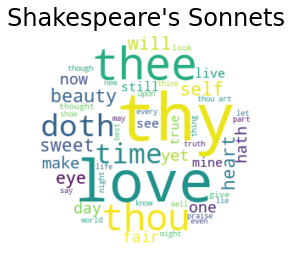

In [155]:
wordcloud = text_to_wordcloud(text, title="Shakespeare's Sonnets")

In order to understand the transition and emission matrices that our code has outputted, we will now visualize the matrix sparsity:

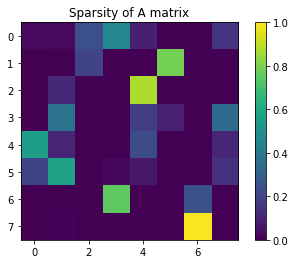

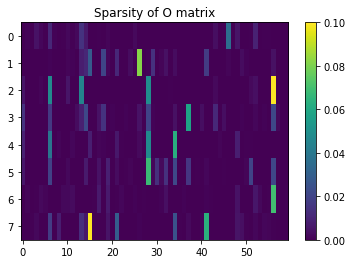

In [208]:
visualize_sparsities(hmm8, O_max_cols=60)

We will visualize wordclouds of the states to assess commonalities and differences:

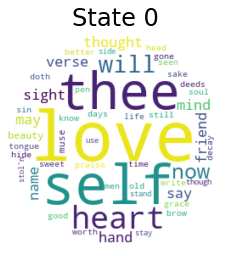

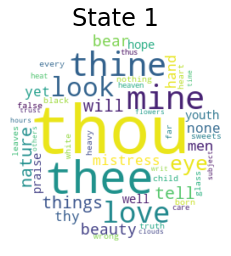

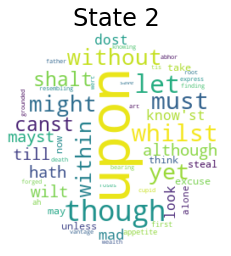

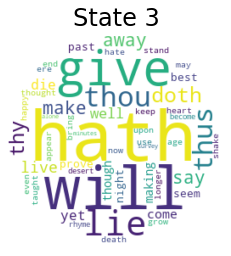

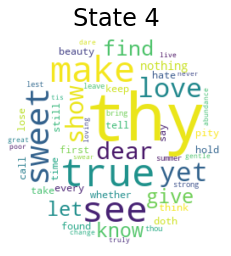

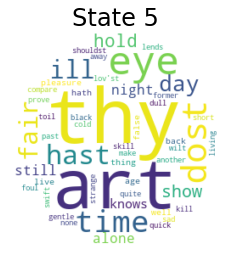

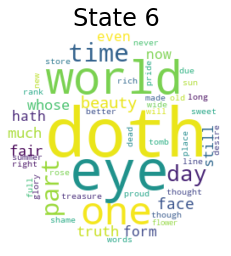

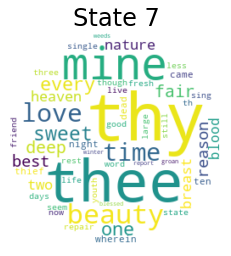

In [209]:
wordclouds = states_to_wordclouds(hmm8, obs_map)

Finally, we can visualize the transititions between states:


Animating...


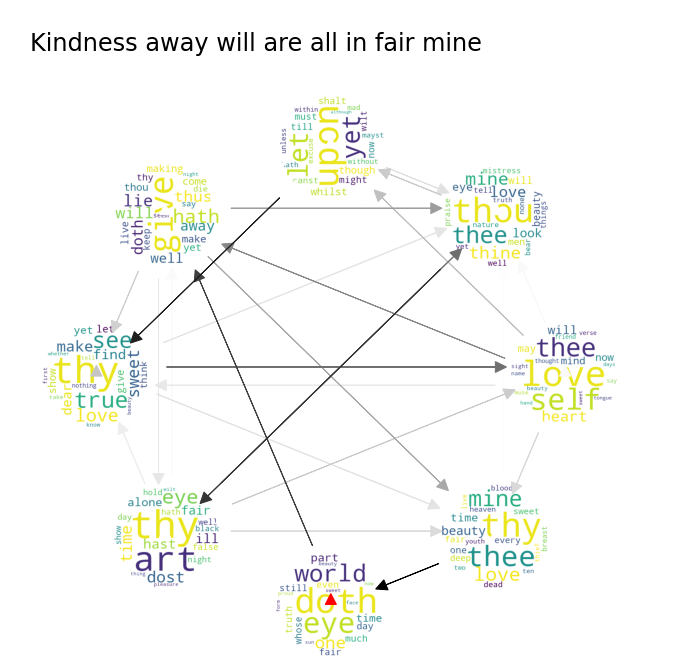

In [161]:
anim = animate_emission(hmm8, obs_map, M=8)
HTML(anim.to_html5_video())

We also want to find the top ten words given a state for 5 states, so we can do that using the following function:

In [197]:
def top_words(hmm, obs_map, state_arr,  max_words=10):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in state_arr:
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        # Get the positions of the unique elements
        unique,pos = np.unique(obs_lst,return_inverse=True) 
        # Count the positions
        counts = np.bincount(pos)
        # Get the max_words largest
        idx = np.argsort(counts)[-10:]
        idx = idx[::-1]
        obs_count.append(unique[idx])
    
    sentences =''
    # For each state, convert it into a list of words.
    for i in range(len(state_arr)):
        topwords = obs_count[i]
        sentence = [obs_map_r[j] for j in topwords]
        sentences += 'State ' + str(state_arr[i]) + ': ' + ' '.join(sentence) + '\n'

    return sentences

The states that we will analyze are states 0, 1, 2, 3, and 6

In [210]:
print(top_words(hmm8, obs_map, [0, 1, 2, 3, 6],  10))

State 0:love self thee me heart it but that will may
State 1:thou me the so thee you by not mine thine
State 2:and i but to that for when o upon then
State 3:of in with is as and to for that from
State 6:and doth which one eye world truth who there some



We can also use NLTK's POS tagger in order to examine what the most common 3 parts of speech are in each state as well:

In [223]:
def top_pos(hmm, obs_map):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        # Convert into words
        words = [obs_map_r[j] for j in obs_lst]
        # Get the parts of speech of each element
        part = [p for (w, p) in nltk.pos_tag(words)]
        # Get the positions of the unique elements
        unique,pos = np.unique(part,return_inverse=True) 
        # Count the positions
        counts = np.bincount(pos)
        # Get the max_words largest
        idx = np.argsort(counts)[-3:]
        idx = idx[::-1]
        obs_count.append(unique[idx])
    
    sentences = ''
    # For each state, print the parts of speech
    total_types =[]
    for i in range(n_states):
        sentences += 'State ' + str(i) + ': ' + ' '.join(obs_count[i]) + '\n'
        total_types.extend(obs_count[i])
    
    # Print the meanings of the codes
    total_types = np.unique(total_types)
    for i in range(len(total_types)):
        nltk.help.upenn_tagset(total_types[i])
    
    return sentences

In [224]:
print(top_pos(hmm8, obs_map))

CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
IN: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...
JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
PRP: pronoun, personal
    hers herself him himself hisself it itself m